In [43]:
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [34]:
student_habits = pd.read_csv("../data/student_habits_performance.csv")
student_habits.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [22]:
student_habits = student_habits.drop("student_id", axis=1)
student_habits

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,21,Female,2.6,0.5,1.6,No,77.0,7.5,Fair,2,High School,Good,6,Yes,76.1
996,17,Female,2.9,1.0,2.4,Yes,86.0,6.8,Poor,1,High School,Average,6,Yes,65.9
997,20,Male,3.0,2.6,1.3,No,61.9,6.5,Good,5,Bachelor,Good,9,Yes,64.4
998,24,Male,5.4,4.1,1.1,Yes,100.0,7.6,Fair,0,Bachelor,Average,1,No,69.7


In [23]:
student_habits.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [37]:
student_habits.isnull().sum()

student_id                       0
age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
exam_score                       0
dtype: int64

No missing values

In [46]:
student_habits.corr()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
age,1.000000,0.003971,-0.009151,-0.001174,-0.026055,0.037482,-0.003836,-0.045101,-0.008907
study_hours_per_day,0.003971,1.000000,0.020282,-0.031158,0.026264,-0.027757,-0.028701,-0.003768,0.825419
social_media_hours,-0.009151,0.020282,1.000000,0.011477,0.040479,0.018236,-0.037319,0.001496,-0.166733
netflix_hours,-0.001174,-0.031158,0.011477,1.000000,-0.002092,-0.000935,-0.006448,0.008034,-0.171779
attendance_percentage,-0.026055,0.026264,0.040479,-0.002092,1.000000,0.013756,-0.007857,-0.018745,0.089836
sleep_hours,0.037482,-0.027757,0.018236,-0.000935,0.013756,1.000000,0.019769,-0.006508,0.121683
exercise_frequency,-0.003836,-0.028701,-0.037319,-0.006448,-0.007857,0.019769,1.000000,-0.000242,0.160107
mental_health_rating,-0.045101,-0.003768,0.001496,0.008034,-0.018745,-0.006508,-0.000242,1.000000,0.321523
exam_score,-0.008907,0.825419,-0.166733,-0.171779,0.089836,0.121683,0.160107,0.321523,1.000000


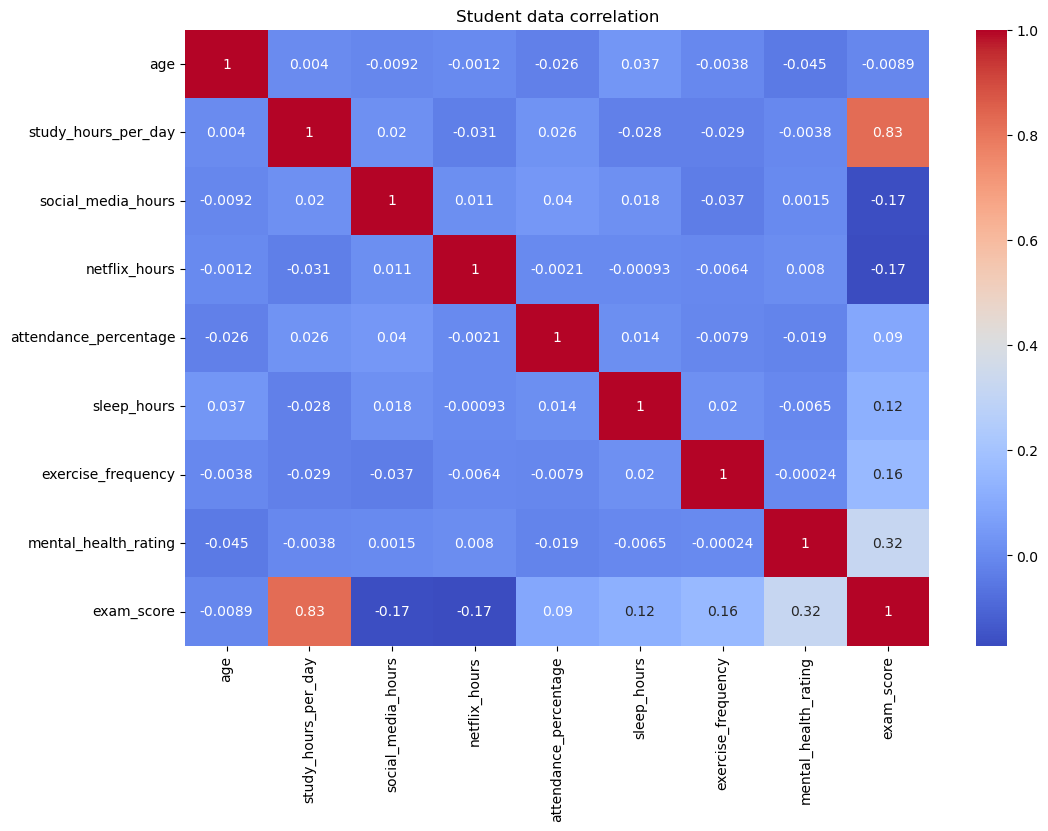

In [27]:
import seaborn as sns

# Create heatmap
plt.figure(figsize=(12,8))
sns.heatmap(student_habits.corr(), annot=True, cmap="coolwarm")
plt.title("Student data correlation")
plt.show()

The only strong relation between our features is the amount of hours studied and final exam score. 
Social media hours and netflix does have a negative effect, however the correlation score is very weak. 

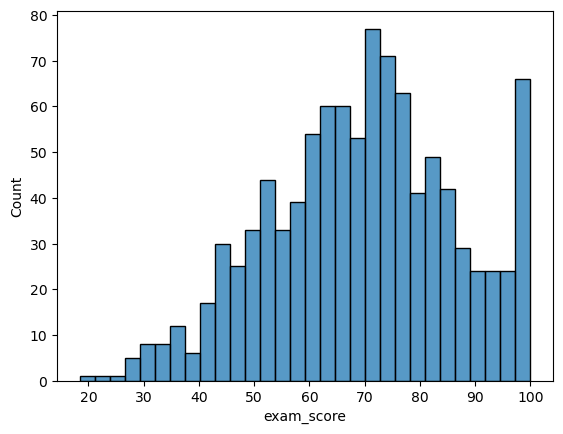

In [41]:
# Distribution of exam scores
sns.histplot(student_habits['exam_score'], bins=30)
plt.show()

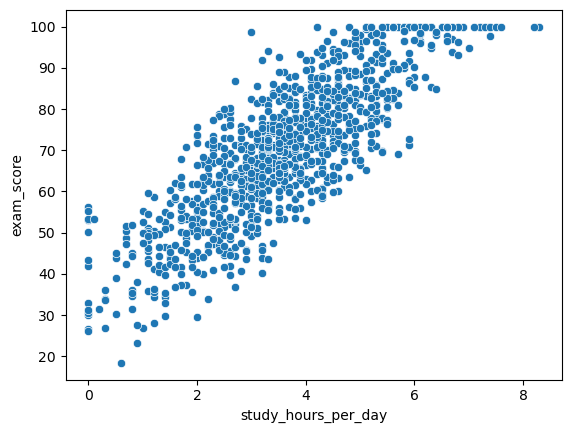

In [45]:

# Scatterplot: study hours vs exam score
sns.scatterplot(data=student_habits, x="study_hours_per_day", y="exam_score")
plt.show()